In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

matplotlib.style.use("ggplot")
import seaborn as sns
import numpy as np
import matplotlib as mpl
import arrow
from matplotlib import animation, rc
from IPython.display import HTML
from datetime import timedelta
import altair as alt
from icecream import ic


%matplotlib inline

In [2]:
#############################################################################
# Prepare data and import into a dataframe
#############################################################################

# Export Data from healthkit using [qs-access](https://itunes.apple.com/us/app/qs-access/id920297614?mt=8) app
# exported_and_trandformed_csv_file = "data/weight.csv"

# Switching to using Auto Export (has other features too)
# Groan, AutoExport has a trailing CSV, add a junk column
exported_and_trandformed_csv_file = "data/metrics-2024-03-08.csv"
df = pd.read_csv(exported_and_trandformed_csv_file, sep=",")
# idx_weight_kg = "Weight (kg)"
idx_weight, min_weight = "Weight/Body Mass (lb)", 140
# idx_weight, min_weight = "Body Fat Percentage (%)", 20
# Weight (lb)"
# make dateColumn a datetime.
idx_date = "Date"
df[idx_date] = pd.to_datetime(df[idx_date])
df = df.set_index(df[idx_date])

# Drop any invalid dates
# df = df.dropna(subset=[idx_date])
df = df.sort_index()
# print number of rows

# Create Time Period Groups
idx_month_year = "month_year"
df[idx_month_year] = df.index.to_series().apply(lambda t: arrow.get(t).format("MMM-YY"))

idx_week_year = "week_year"
df[idx_week_year] = df.index.to_series().apply(lambda t: f"{t.week}-{t.year-2000}")

idx_quarter_year = "quarter_year"
df[idx_quarter_year] = df.index.to_series().apply(
    lambda t: arrow.get(t).ceil("quarter").format("MMM-YY")
)

#########################
# Clean data
###########################



# Remove 0 weight values.
df = df.replace(0, np.nan)

# remove data before 2010
df = df[df.index > "2010-01-01"]


# (not sure why mypy can't handle this)
# KG to lbs
# df[idx_weight] = df[idx_weight_kg] * 2.2
# df[idx_weight] = df[idx_weight_kg]

# Throw away any weights less then minimum as bad data
df = df[df[idx_weight] > min_weight]

dfW = df[idx_weight]


# Remove any rows with 0 values


# Helpful time aliases
df_alltime = df
display(df)

,Date,Body Fat Percentage (%),Heart Rate Variability (ms),Low Heart Rate Notifications [Min] (count),Low Heart Rate Notifications [Max] (count),Low Heart Rate Notifications [Avg] (count),Resting Heart Rate (bpm),Sleep Analysis [Asleep] (hr),Sleep Analysis [In Bed] (hr),Sleep Analysis [Core] (hr),Sleep Analysis [Deep] (hr),Sleep Analysis [REM] (hr),Sleep Analysis [Awake] (hr),VO2 Max (ml/(kg·min)),Weight/Body Mass (lb),Junk,month_year,week_year,quarter_year
Date,,,,,,,,,,,,,,,,,,,
2015-09-26,2015-09-26,NaN,NaN,NaN,NaN,NaN,NaN,8.750278,NaN,NaN,NaN,NaN,NaN,NaN,164.0,NaN,Sep-15,39-15,Sep-15
2015-09-28,2015-09-28,NaN,NaN,NaN,NaN,NaN,NaN,3.514167,NaN,NaN,NaN,NaN,NaN,NaN,164.0,NaN,Sep-15,40-15,Sep-15
2015-09-29,2015-09-29,NaN,NaN,NaN,NaN,NaN,NaN,6.821944,NaN,NaN,NaN,NaN,NaN,NaN,161.0,NaN,Sep-15,40-15,Sep-15
2015-09-30,2015-09-30,NaN,NaN,NaN,NaN,NaN,NaN,6.983333,NaN,NaN,NaN,NaN,NaN,NaN,154.0,NaN,Sep-15,40-15,Sep-15
2015-10-05,2015-10-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,169.0,NaN,Oct-15,41-15,Dec-15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-03,2024-03-03,24.9,36.66,NaN,NaN,NaN,59.0,9.266667,10.533333,5.558333,0.733333,NaN,0.533333,NaN,187.6,NaN,Mar-24,9-24,Mar-24
2024-03-04,2024-03-04,NaN,46.48,NaN,NaN,NaN,61.0,8.516667,8.834628,5.350000,0.708333,NaN,0.116667,NaN,186.6,NaN,Mar-24,10-24,Mar-24
2024-03-06,2024-03-06,23.7,52.26,NaN,NaN,NaN,58.0,7.183333,7.741667,5.325000,0.550000,NaN,0.058333,NaN,186.8,NaN,Mar-24,10-24,Mar-24


In [3]:
def box_plot_weight_mpl(df, x, title=""):
    # In theory can use plot.ly (not free)  or Bokeh (not mpl compatible) but issues. So setting dimensions old school.
    # Manually setting the weight and width.
    height_in_inches = 8
    mpl.rc("figure", figsize=(4 * height_in_inches, height_in_inches))

    ax = sns.boxplot(x=x, y=idx_weight, data=df)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.set_title(title)
    ax.set_xlabel("date")
    ax.set_ylabel("lbs")
    plt.show()


def box_plot_weight_vegas(df, x, title, domain=(150, 250)):
    height_in_inches = 4 * 60  # todo figure out how to get this by calculation
    y_min = min(df[idx_weight]) - 10 
    y_max = max(df[idx_weight]) + 10
    domain=(y_min,y_max)
    display(domain)
    c = (
        alt.Chart(df)
        .mark_boxplot()
        .encode(y=alt.Y(idx_weight, scale=alt.Scale(domain=domain, clamp=True)), x=x)
        .properties(width=4 * height_in_inches, height=height_in_inches, title=title)
        .interactive()
    )
    display(c)

Timestamp('2023-03-09 00:00:00')

/var/folders/87/1kxmqyhj17v2x2qhrs3x5hhr0000gn/T/ipykernel_79207/513703513.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


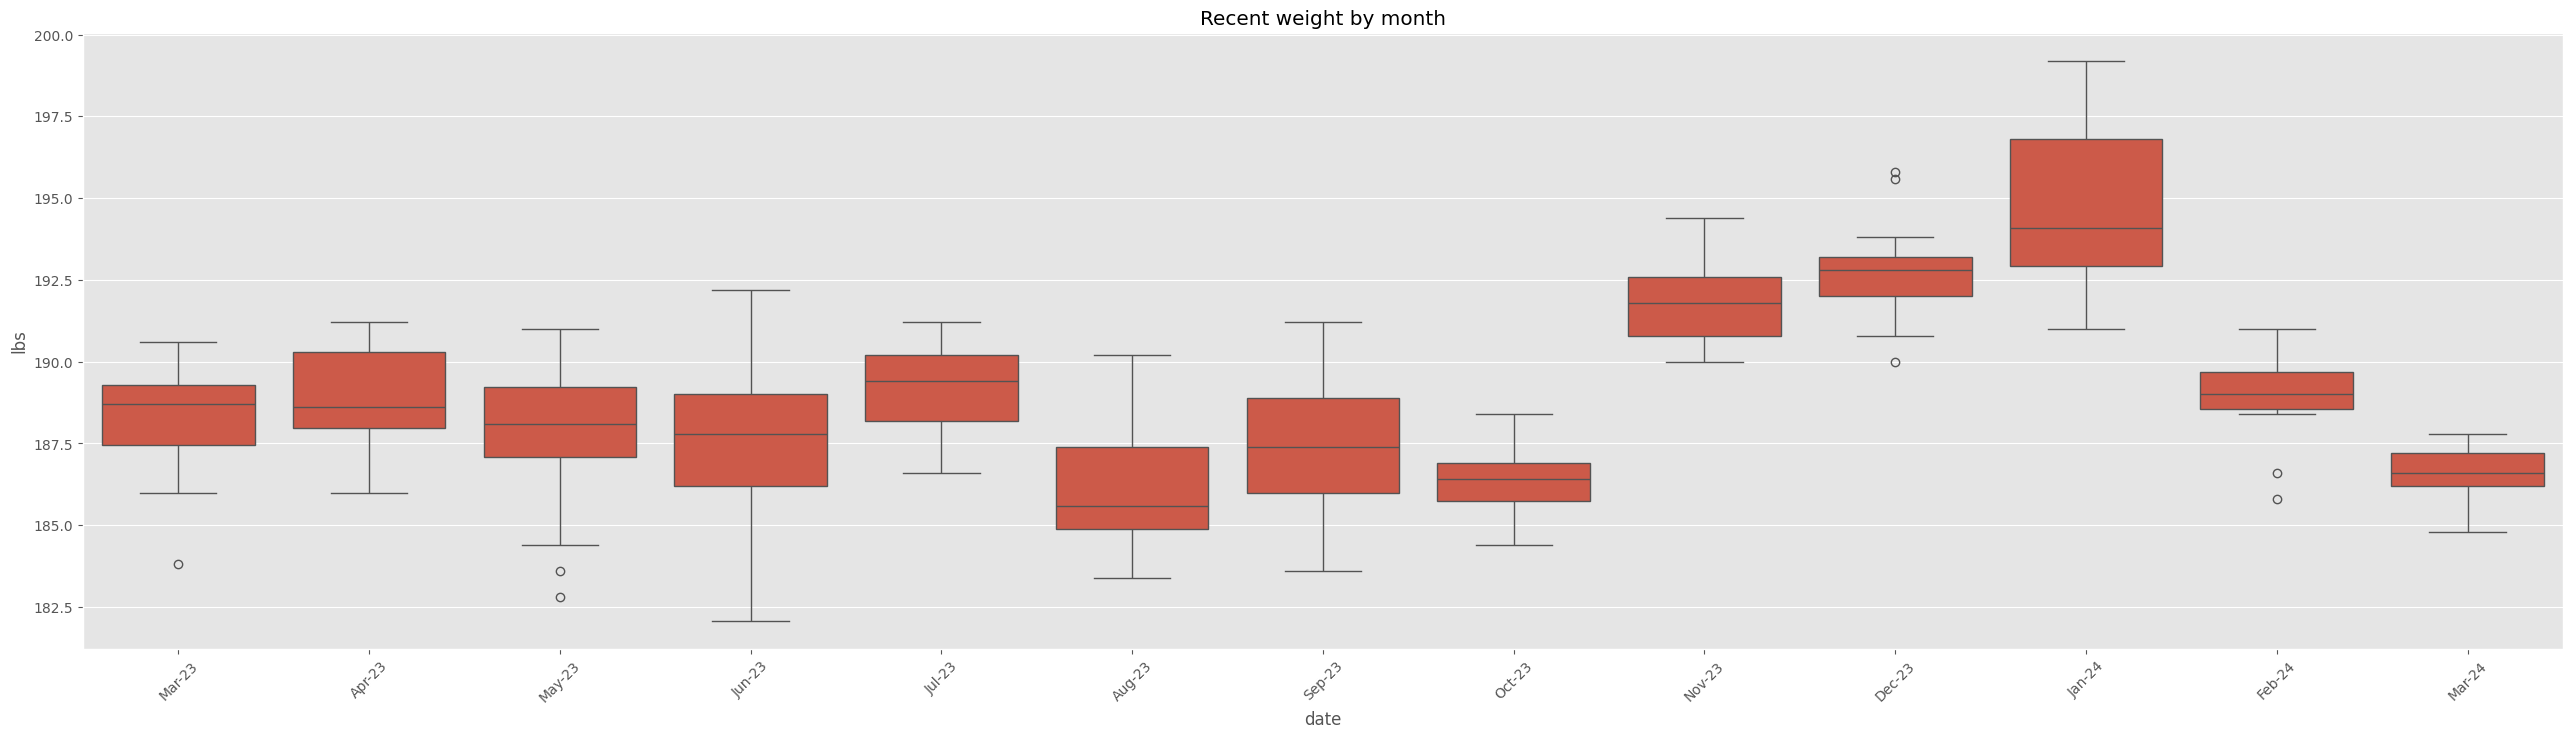

/var/folders/87/1kxmqyhj17v2x2qhrs3x5hhr0000gn/T/ipykernel_79207/513703513.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


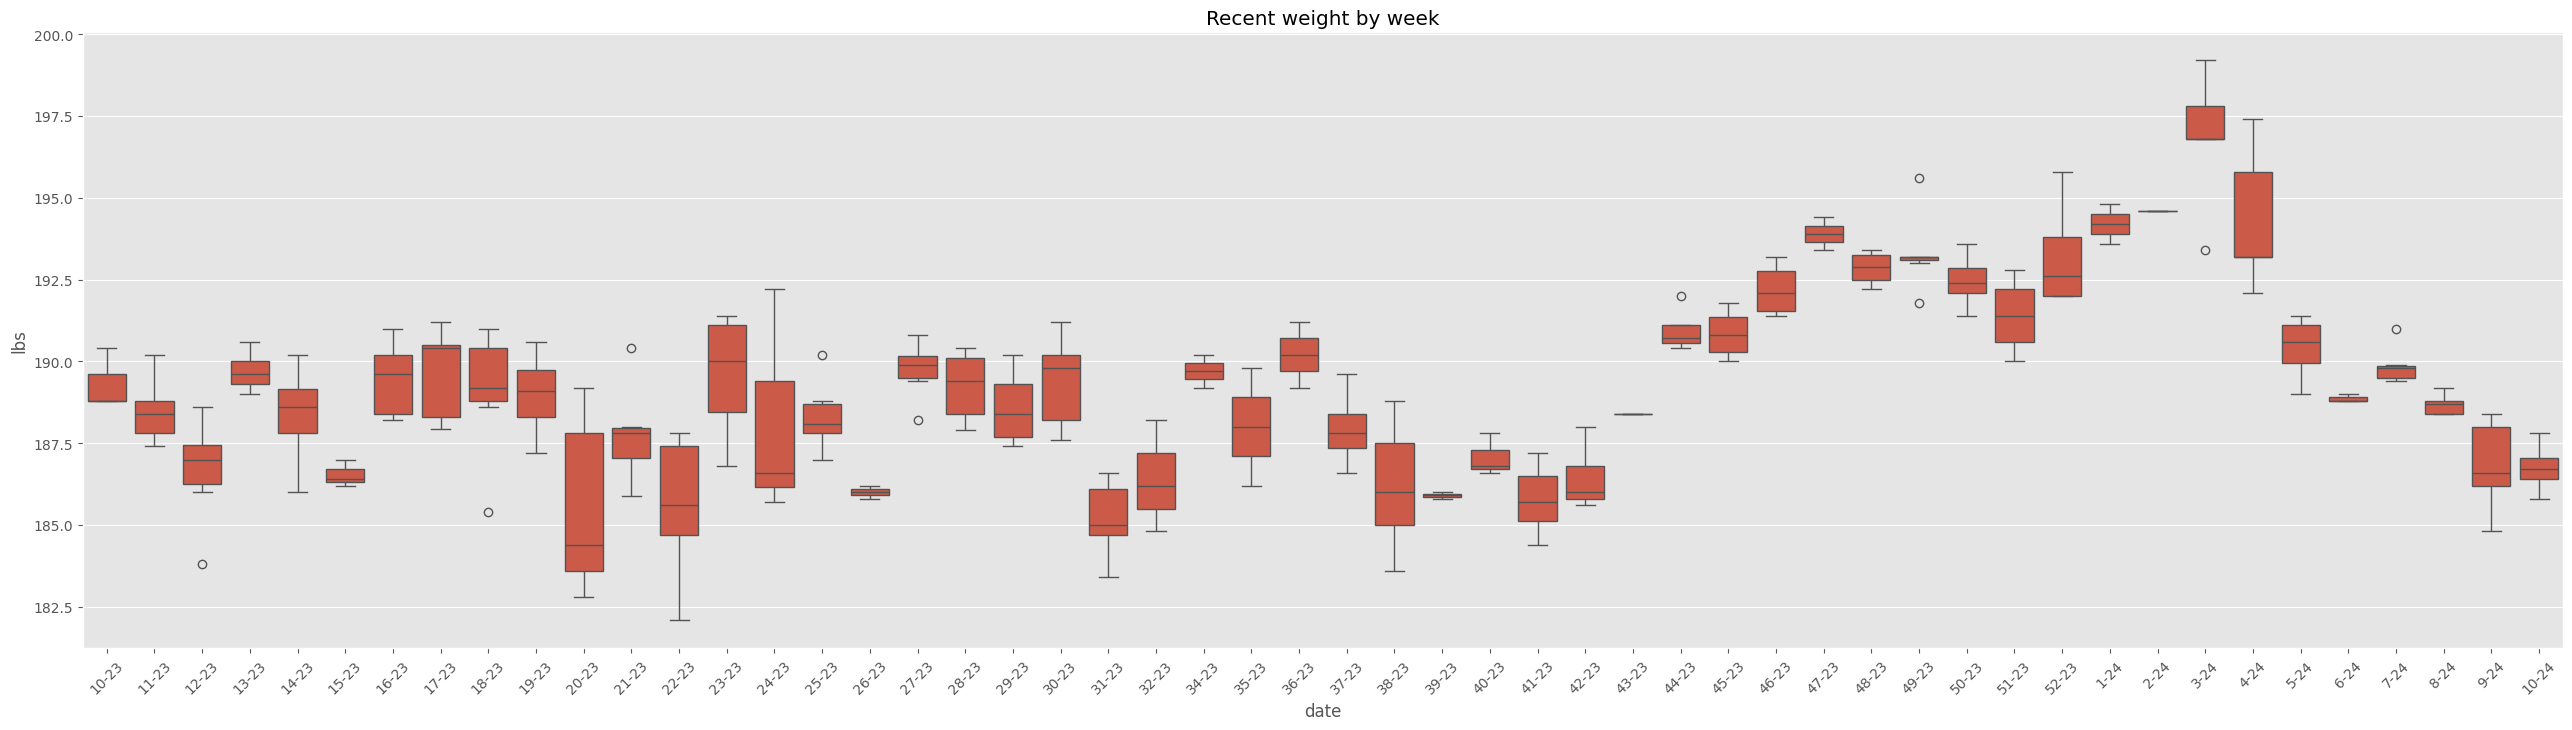

/var/folders/87/1kxmqyhj17v2x2qhrs3x5hhr0000gn/T/ipykernel_79207/513703513.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


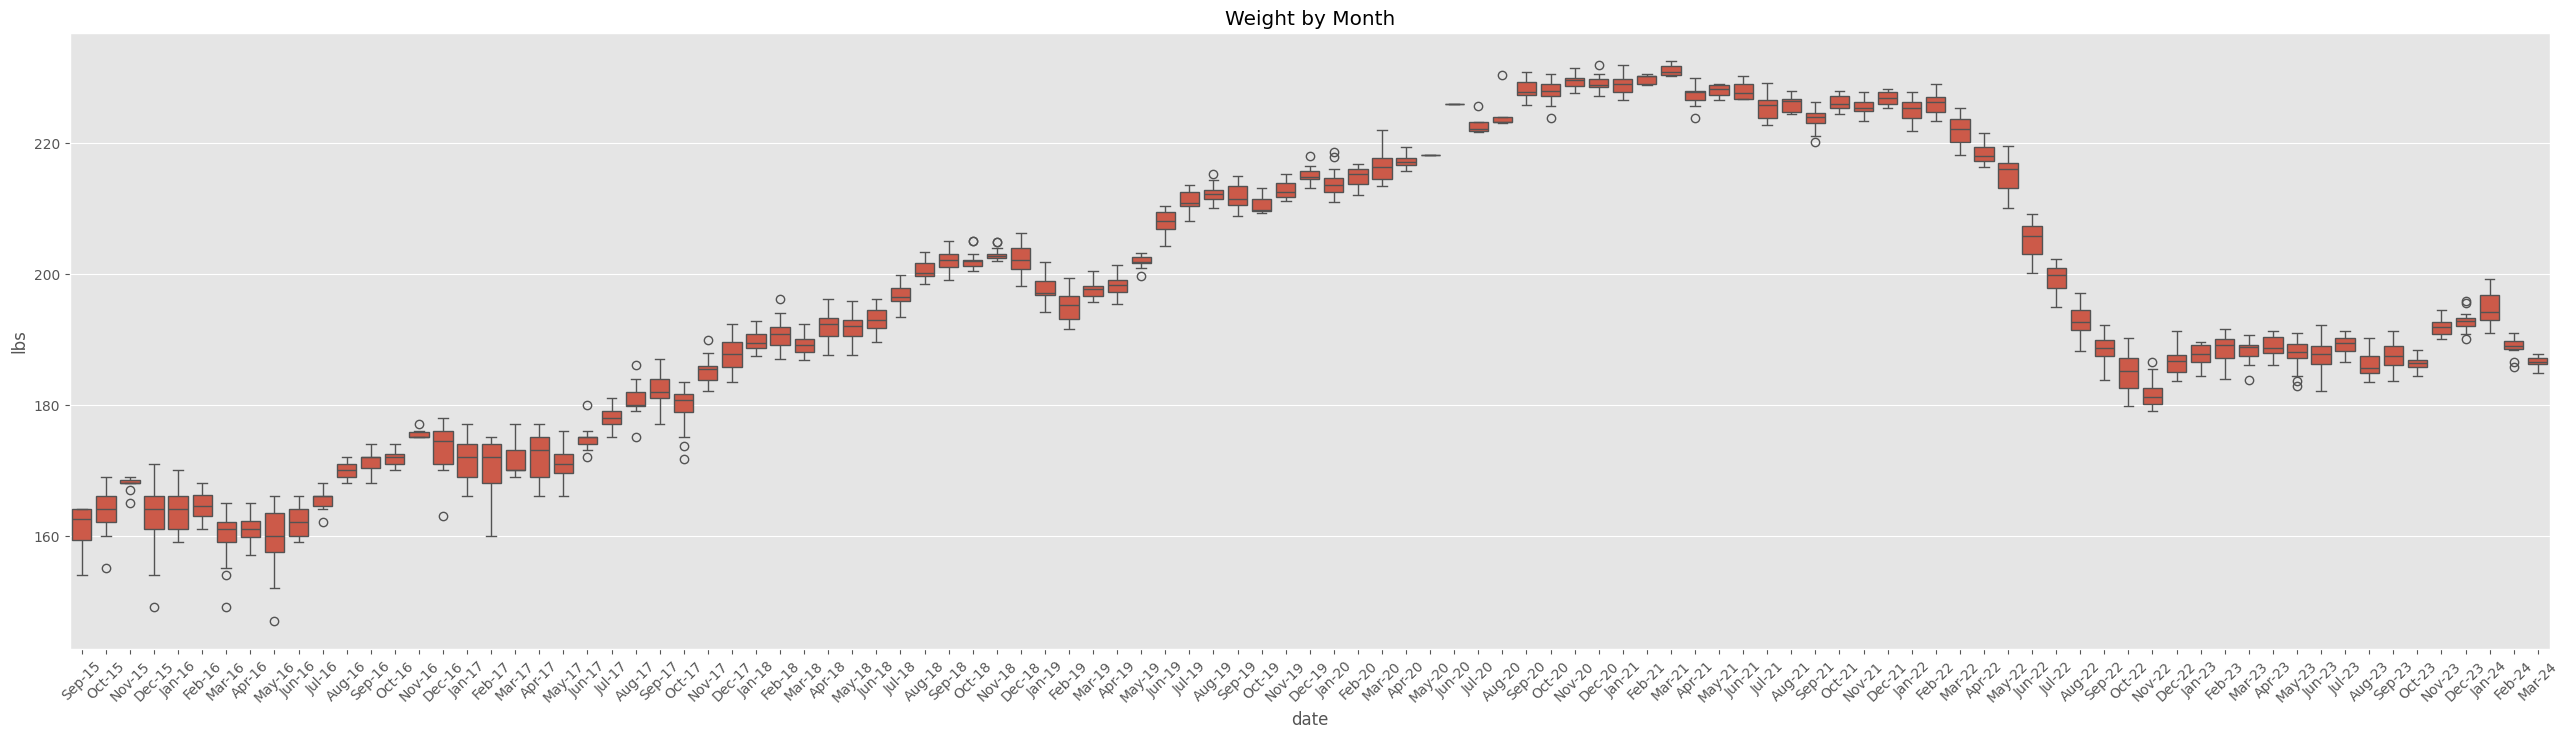

/var/folders/87/1kxmqyhj17v2x2qhrs3x5hhr0000gn/T/ipykernel_79207/513703513.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)


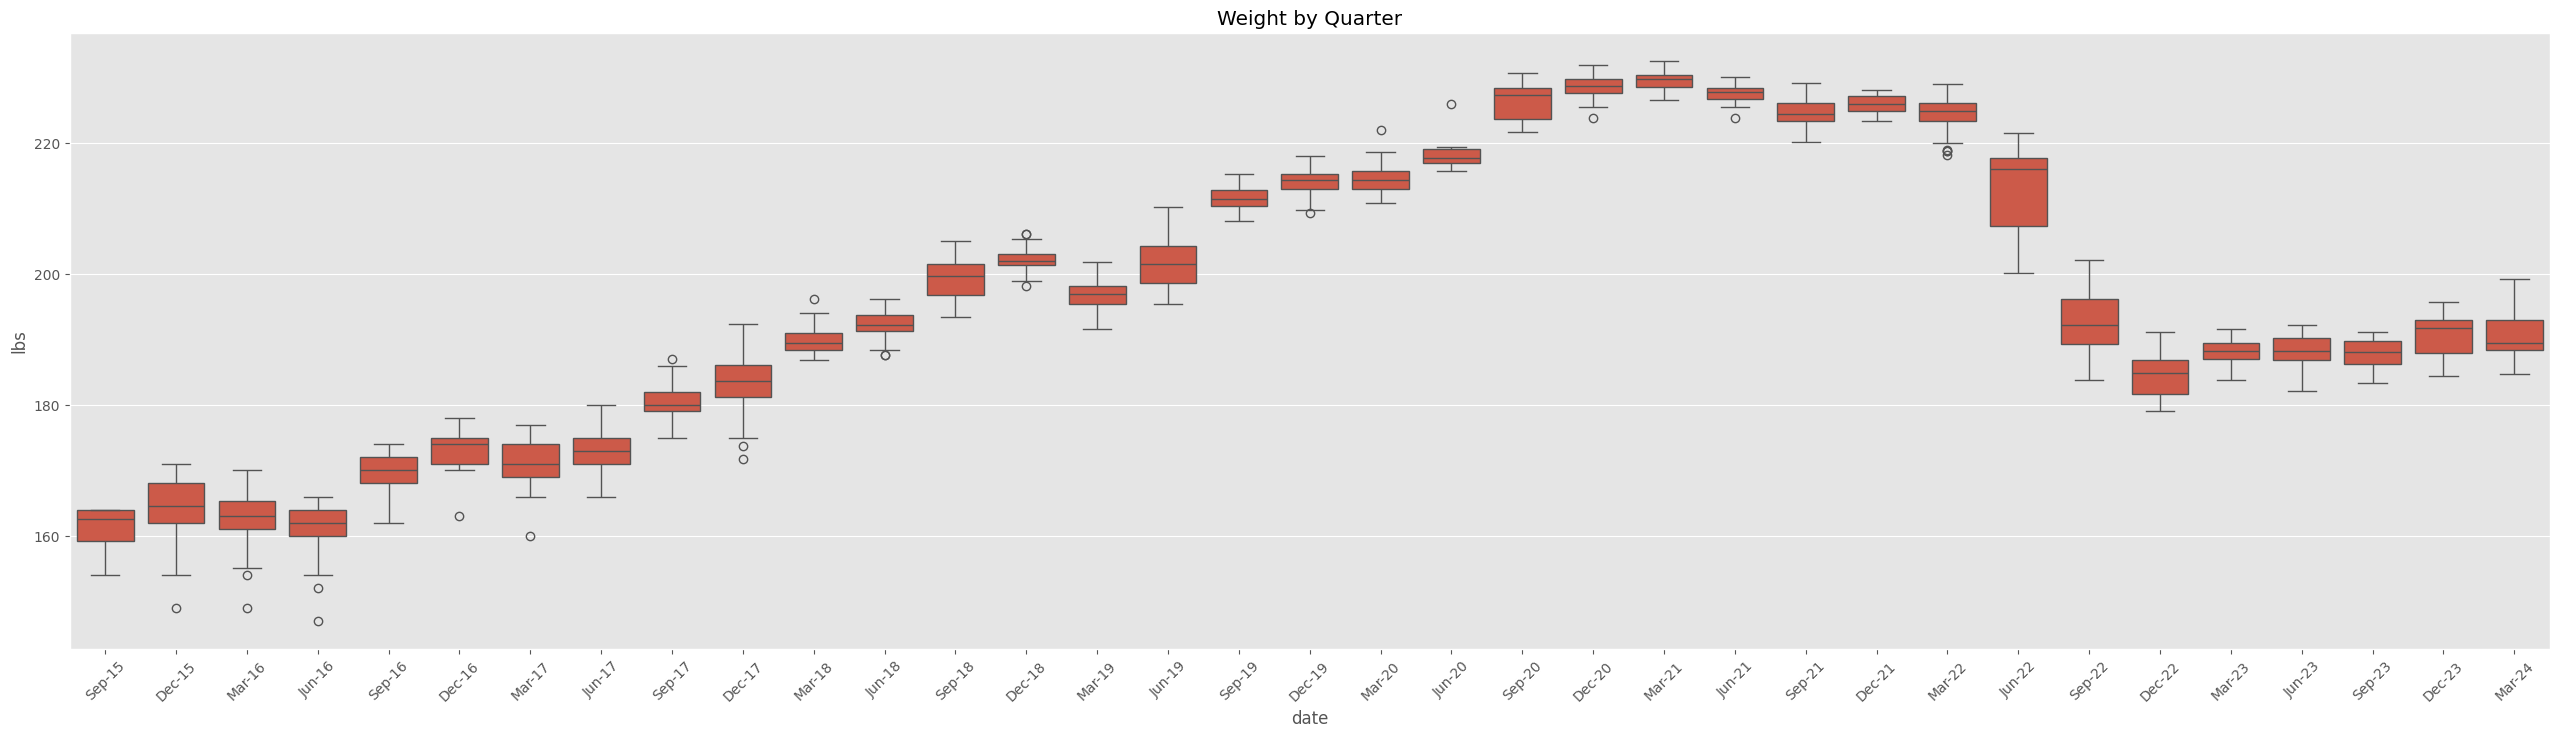

In [4]:
earliest = df.iloc[-1].Date - pd.DateOffset(years=1)
display(earliest)
box_plot_weight = box_plot_weight_mpl
# vegas box plot doesnt' sort by date - it sorts by string - yuk!
box_plot_weight(df[earliest:], idx_month_year, title="Recent weight by month")
box_plot_weight(df[earliest:], idx_week_year, title="Recent weight by week")
box_plot_weight(df_alltime, idx_month_year, "Weight by Month")
box_plot_weight(df_alltime, idx_quarter_year, "Weight by Quarter")

# Time Series Analysis using resampling

In [5]:
print("Scroll to see year markers, select in index to zoom in")
metric = idx_weight


def graph_weight_as_line(df, freq, domain):
    pd_freq_value = freq[0]  # hack, pandas Freq are D,W,M
    df_group_time = df.copy()[metric].resample(pd_freq_value)
    t1 = df_group_time.count().reset_index()
    # Create the root df for output
    df_to_graph = t1.drop(columns=metric)
    for q in [0.25, 0.5, 0.9]:
    # for q in [0.25, 0.9]:
        df_to_graph[f"p{q*100}"] = df_group_time.quantile(q).reset_index()[metric]

    # Now start adding back the rows
    df_melted = df_to_graph.melt(id_vars=[idx_date])
    
    height_in_inches = 60  # todo figure out how to get this by calculation
    
    selection = alt.selection_point(fields=["variable"], bind="legend")  # Updated to Altair 5's selection_point
    
    c = (
        alt.Chart(df_melted)
        .mark_line(point=True)
        .encode(
            y=alt.Y("value", title="", scale=alt.Scale(domain=domain)),
            x=alt.X(f"{idx_date}:T"),
            color=alt.Color("variable"),
            tooltip=[alt.Tooltip(f"{idx_date}:T"), alt.Tooltip("value:Q")],
            opacity=alt.condition(selection, alt.value(1), alt.value(0.2)),
        )
        .properties(
            width=16 * height_in_inches,
            height=6 * height_in_inches,
            title=f"{metric} By {freq}",
        )
        .interactive()
    ).add_params(selection)  # Updated to Altair 5's add_params
    display(c)
    
    return c


earliest = df.iloc[-1].Date - pd.DateOffset(years=1)
graph_weight_as_line(df[earliest:], "Week", (180,205))
for freq in "Month Week".split():
    graph_weight_as_line(df, freq, (150, 240))

Scroll to see year markers, select in index to zoom in


alt.Chart(...)

/var/folders/87/1kxmqyhj17v2x2qhrs3x5hhr0000gn/T/ipykernel_79207/4190558063.py:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df_group_time = df.copy()[metric].resample(pd_freq_value)


alt.Chart(...)

alt.Chart(...)

In [6]:
dfM = dfW.resample("W").median()

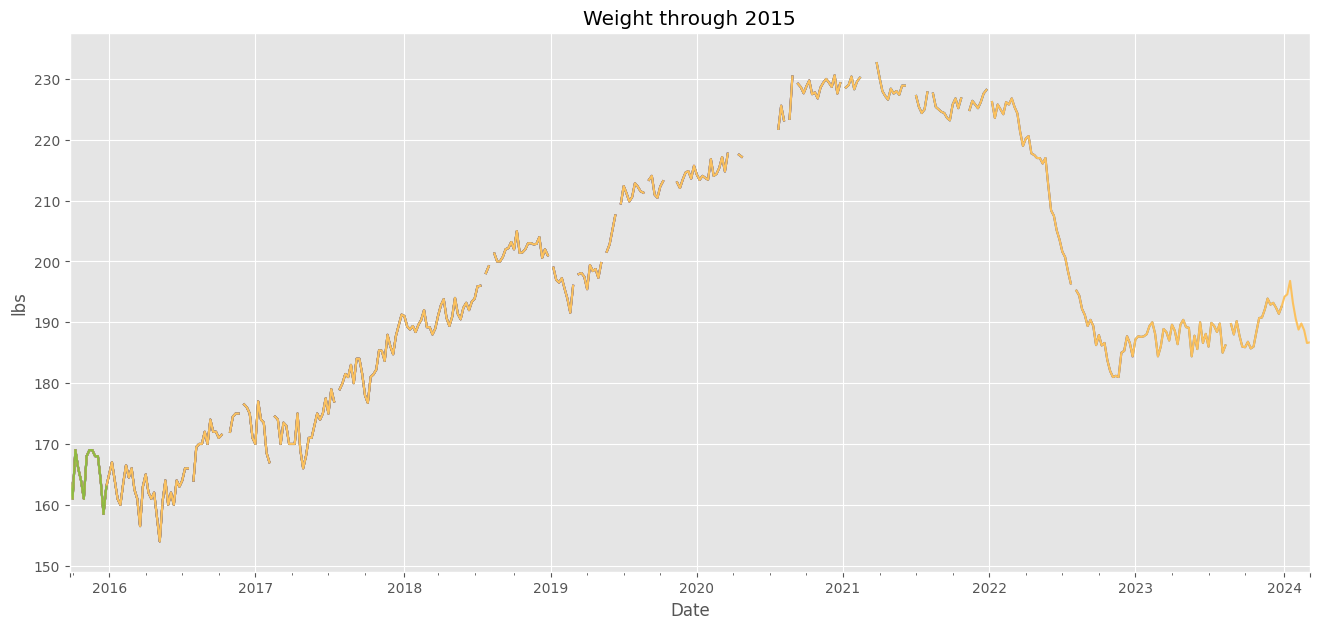

In [7]:
import datetime

anim_year_base = 2015
years_to_plot = datetime.datetime.now().year - anim_year_base + 1
anim_fig_size = (16, 7)
fig = plt.figure(figsize=anim_fig_size)
ax = fig.add_subplot(1, 1, 1)

dfRelevant = dfM[f"{anim_year_base}":f"{anim_year_base+years_to_plot}"]
min_weight = dfRelevant.min() - 5
max_weight = dfRelevant.max() + 5
# TODO Generate the axis limits programatically


dfM[f"{anim_year_base}":f"{anim_year_base}"].plot(
    title=f"Title Over Written",
    figsize=anim_fig_size,
    ylim=(min_weight, max_weight),
    ax=ax,
)
ax.set_ylabel("lbs")
ax.set_xlabel("")


def animate(i):
    year = f"{anim_year_base+i}"
    return dfM[f"{anim_year_base}":year].plot(title=f"Weight through {year}").lines


anim = animation.FuncAnimation(
    fig,
    animate,
    frames=years_to_plot,
    interval=timedelta(seconds=2).seconds * 1000,
    blit=False,
)
HTML(anim.to_html5_video())
# TODO - how to get rid of the initial plot from animate.init() -- no clue.

In [8]:
dfM.min()

np.float64(154.0)

In [9]:
from pandasai import PandasAI
from pandasai.llm.openai import OpenAI
from icecream import ic

ModuleNotFoundError: No module named 'pandasai'

In [ ]:
def setup_gpt():
    import os
    import json

    PASSWORD = "replaced_from_secret_box"
    with open(os.path.expanduser("~/gits/igor2/secretBox.json")) as json_data:
        SECRETS = json.load(json_data)
        PASSWORD = SECRETS["openai"]
    return PASSWORD


from pandasai.llm.openai import OpenAI

# model = "gpt-4"
model = "gpt-3.5-turbo"
llm = OpenAI(setup_gpt(), model=model)
pandas_ai = PandasAI(llm, verbose=True)
exported_and_trandformed_csv_file = "data/weight.csv"
df = pd.read_csv(exported_and_trandformed_csv_file)
pandas_ai.run(df, "Remove rows with weights less then 100 from", show_code=True)
# df = df[df[idx_weight] > 100]

pandas_ai.run(df, prompt="What is the average weight?", show_code=False)

In [ ]:
prompt = f"""
Graph  P5, P50 and P90 Weight over time, let the x axis be every quarter 
"""
# pandas_ai.run(df, prompt=prompt, show_code=True)